# Import Libraries

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import seaborn as sns
import re
import os

sns.set()

# Config Class

In [158]:
class Config:
    PATH_TRAIN="../data/train.csv"
    PATH_TEST="../data/test.csv"
    PATH_SUBMIT_EXAMPLE="../data/gender_submission.csv"
    PATH_SUBMIT="../submits/"
    TARGET_COL="Survived"
    INDEX_COL="PassengerId"
    RANDOM_STATE=32

In [154]:
df_train=pd.read_csv(Config.PATH_TRAIN,index_col=Config.INDEX_COL)
df_test=pd.read_csv(Config.PATH_TEST,index_col=Config.INDEX_COL)

In [129]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [130]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Utilities

In [132]:
def get_missing(df,plot=True,rotation=45,figsize=(10,5),**kwargs):
    labels,values,percent = list(),list(),list()
    if df.isna().sum().sum()>0:
        for column in df.columns:
            if df[column].isna().sum():
                labels.append(column)
                values.append(df[column].isna().sum())
                percent.append((df[column].isna().sum() / df.shape[0])*100)
        #Make a dataframe
        missings=pd.DataFrame({'Features':labels,'MissingValues':values,'MissingPercent':percent}).sort_values(by='MissingPercent',ascending=False)

        if plot:
            plt.figure(figsize=figsize)
            sns.barplot(x=missings.Features,y=missings.MissingPercent).set_title('The Percentage of Missing Values',size=22)
            locs, labels = plt.xticks()
            plt.setp(labels, rotation=rotation,size=16)
            plt.xlabel('Features',size=18)
            plt.ylabel('MissingPercent',size=18)

        return missings.style.set_properties(**{'background-color': 'black','color': 'white'})
    else:
        return False

def get_correlation_target(X,y,plot=True,rotation=45,vertical=True,figsize=(10,5),**kwargs):
    labels,values = list(),list()

    corr = pd.DataFrame(X.corrwith(y).sort_values(ascending=False))
    #Make a dataframe
    corr = X.corrwith(y).sort_values(ascending=False)
    corr = pd.DataFrame({"Features":corr.index,"Correlation":corr.values})
    if plot:
        plt.figure(figsize=figsize)
        if vertical:
            sns.barplot(x=corr["Features"],y=corr["Correlation"],**kwargs).set_title('Features Correlation with Target',size=22)
            locs, labels = plt.xticks()
            plt.setp(labels, rotation=rotation,size=16)
            plt.xlabel('Features',size=18)
            plt.ylabel('Correlation',size=18)
        else:
            sns.barplot(x=corr["Correlation"],y=corr["Features"],**kwargs).set_title('Features Correlation with Target',size=22)
            locs, labels = plt.yticks()
            plt.setp(labels,size=16)
            plt.xlabel('Correlation',size=18)
            plt.ylabel('Features',size=18)

    return corr.style.set_properties(**{'background-color': 'black','color': 'white'})

def get_correlation_features(df,plot=True,figsize=(10,5),**kwargs):
    corr=df.corr()
    if plot:
        plt.figure(figsize=figsize)
        sns.heatmap(df.corr(),annot=True,fmt=".2",**kwargs)
    return corr.style.set_properties(**{'background-color': 'black','color': 'white'})

<h2>Get Missing Values

,Features,MissingValues,MissingPercent
1,Cabin,687,77.104377
0,Age,177,19.865320
2,Embarked,2,0.224467


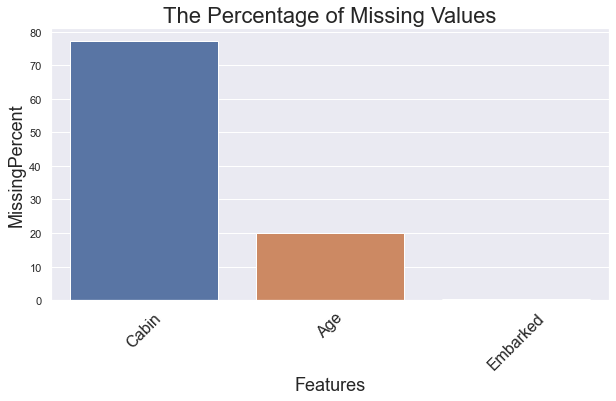

In [133]:
get_missing(df_train)

<h2>Get Correlation Before Preprocessing

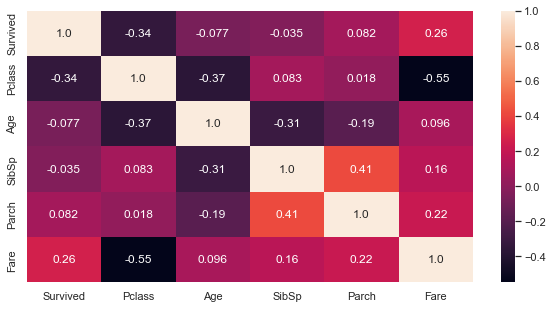

In [170]:
get_correlation_features(df_train);

,Features,Correlation
0,Fare,0.257307
1,Parch,0.081629
2,SibSp,-0.035322
3,Age,-0.077221
4,Pclass,-0.338481


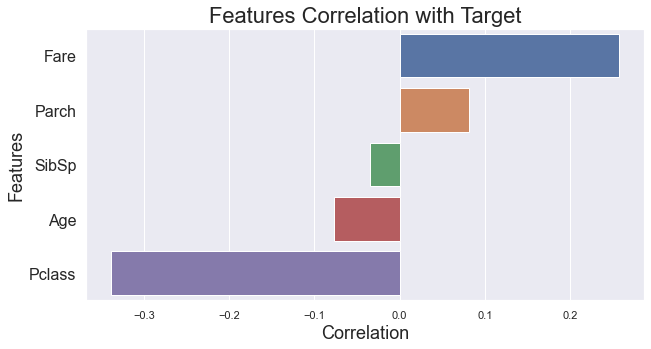

In [172]:
get_correlation_target(df_train.drop(Config.TARGET_COL,axis=1) ,df_train[Config.TARGET_COL],vertical=False)

<h2>Exploring Features Distribution

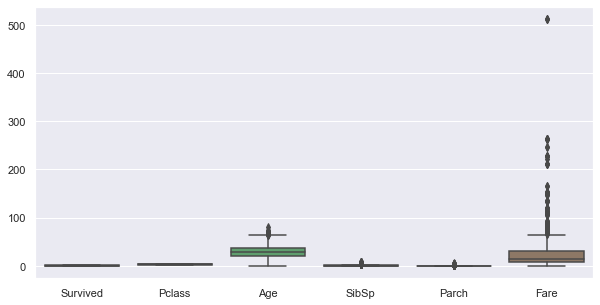

In [173]:
plt.figure(figsize=(10,5));
sns.boxplot(data=df_train);

<h2>Exploring Fare Feature
<p>in this feature exist outliers

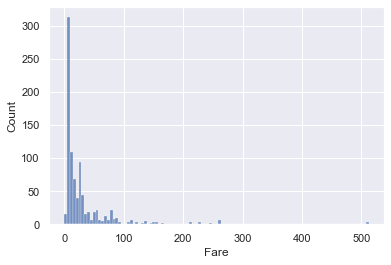

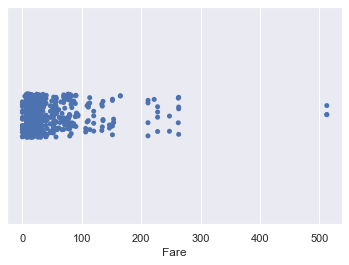

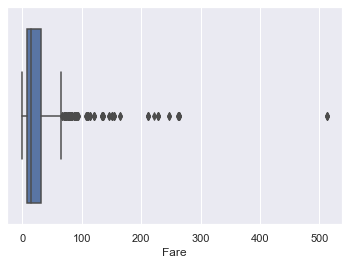

In [134]:
sns.histplot(data=df_train,x="Fare");
plt.show()
sns.stripplot(data=df_train,x="Fare");
plt.show()
sns.boxplot(data=df_train,x="Fare");
plt.show()

In [167]:
Q3=df_train["Fare"].quantile(0.75)
IQR=df_train["Fare"].quantile(0.75)-df_train["Fare"].quantile(0.25)
UB=Q3+1.5*IQR
print("upper bound:",UB)
print("drop percent(UB):",df_train[df_train["Fare"]>=UB]['Fare'].count()/df_train['Fare'].count())
print("drop percent(200):",df_train[df_train["Fare"]>=200]['Fare'].count()/df_train['Fare'].count())

upper bound: 65.6344
drop percent(UB): 0.13019079685746351
drop percent(200): 0.02244668911335578


13% is a important data drop for convention "Q3 + 1.5*IQR" , I'm opted for using 200 as upper bound

# Preprocessing

In [136]:
AgePclass1=(df_train[df_train["Pclass"]==1]["Age"].median())
AgePclass2=(df_train[df_train["Pclass"]==2]["Age"].median())
AgePclass3=(df_train[df_train["Pclass"]==3]["Age"].median())

FarePclass1=(df_train[df_train["Pclass"]==1]["Fare"].median())
FarePclass2=(df_train[df_train["Pclass"]==2]["Fare"].median())
FarePclass3=(df_train[df_train["Pclass"]==3]["Fare"].median())
print(AgePclass1)
print(AgePclass2)
print(AgePclass3)

print(FarePclass1)
print(FarePclass2)
print(FarePclass3)

37.0
29.0
24.0
60.287499999999994
14.25
8.05


In [137]:
def prepro(X) -> pd.DataFrame: # for this dataset Only
    # imputing Embarked missing values with the most frequent value
    embarked_most_frequent=X["Embarked"].mode()[0]
    X.loc[X["Embarked"].isna(),"Embarked"]=embarked_most_frequent

    # imputing Age by Pclass
    X.loc[X["Age"].isna() & (X["Pclass"]==1) , "Age"] = AgePclass1
    X.loc[X["Age"].isna() & (X["Pclass"]==2) , "Age"] = AgePclass2
    X.loc[X["Age"].isna() & (X["Pclass"]==3) , "Age"] = AgePclass3

    # imputing Fare by Pclass
    X.loc[X["Fare"].isna() & (X["Pclass"]==1) , "Fare"] = FarePclass1
    X.loc[X["Fare"].isna() & (X["Pclass"]==2) , "Fare"] = FarePclass2
    X.loc[X["Fare"].isna() & (X["Pclass"]==3) , "Fare"] = FarePclass3


    # Mapping Sex
    gender_dict={'male':1,'female':0}
    X["Sex"].replace(gender_dict,inplace=True)

    # Mapping Embarked
    embarked_dict = {'S':0, 'C':1, 'Q':2}
    X["Embarked"].replace(embarked_dict,inplace=True)

    # add new features
    X['Fare/(Pclass+1)']= X['Fare']/(X['Pclass']+1)
    X["Parch/(SibSp+1)"]= X["Parch"]/(X["SibSp"]+1)
    X['Fare*(Embarked+1)']= X['Fare']*(X['Pclass']+1)
    # X['Fare/((Sex+1)']= X['Fare']/(X['Sex']+1)

    X.drop(["Name","Parch","SibSp"],axis=1,inplace=True)

    return X

def drop_outliers(X: pd.DataFrame, columns="__All__"):
    """
        columns: list of strings
    """
    if columns=="__All__":
        columns=X.columns

    for col in columns:
        if col=="Fare":
            outliers = X[col]>200
            X.drop(X[outliers].index,inplace=True)
            continue
        Q1=X[col].quantile(0.25)
        Q3=X[col].quantile(0.75)
        IQR=Q3-Q1
        LB=Q1-2*IQR
        UB=Q3+2*IQR
        outliers = (X[col]<LB) | (X[col]>UB)
        X.drop(X[outliers].index,inplace=True)
    return X

def to_tensor(X: pd.DataFrame) -> np.array:
    X=X.copy()
    rows,cols=X.shape
    X_tensor=(X.values.reshape((rows, cols, 1)) @ X.values.reshape((rows, 1, cols)))

    return X_tensor.reshape((rows,cols,cols,1))

<h2>Preprocessing Train Data

In [139]:
X = df_train.drop(["Cabin","Ticket",Config.TARGET_COL],axis=1)
y=df_train[Config.TARGET_COL]
X=prepro(X)
get_missing(X)

False

<h2>Preprocessing Test data

In [140]:
X_test = df_test.drop(["Cabin","Ticket"],axis=1)
X_test=prepro(X_test)
get_missing(X_test)

False

# Correlation After Preprocessing

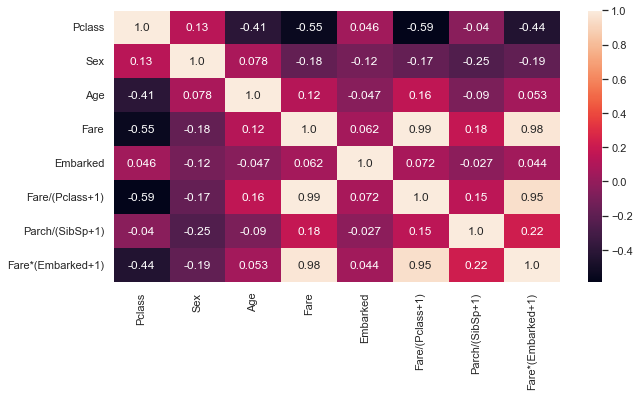

In [174]:
get_correlation_features(X);

,Features,Correlation
0,Fare/(Pclass+1),0.266678
1,Fare,0.257307
2,Fare*(Embarked+1),0.224946
3,Parch/(SibSp+1),0.134738
4,Embarked,0.106811
5,Age,-0.047255
6,Pclass,-0.338481
7,Sex,-0.543351


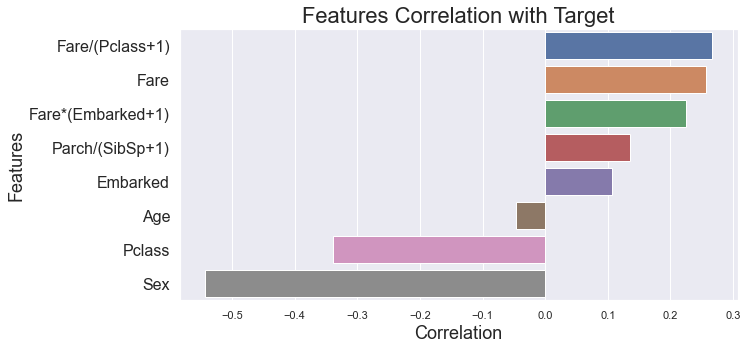

In [141]:
get_correlation_target(X,df_train[Config.TARGET_COL],vertical=False)

# Train Test Split

In [143]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30)

In [147]:
X_train=drop_outliers(X_train,["Fare"])
y_train=y_train[X_train.index]

# Define Neural Network Model

In [148]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[X_train.shape[1]]),

    layers.BatchNormalization(),
    layers.Dropout(0.08),
    layers.Dense(648,activation='relu', kernel_initializer='uniform', bias_initializer='zeros'),

    layers.Dropout(0.8),
    layers.BatchNormalization(),
    layers.Dense(984,activation='relu', kernel_initializer='uniform', bias_initializer='zeros'),

    layers.Dropout(0.54),
    layers.BatchNormalization(),
    layers.Dense(830,activation='relu', kernel_initializer='uniform', bias_initializer='zeros'),

    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 648)               5832      
                                                                 
 dropout_7 (Dropout)         (None, 648)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 648)              2592      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 984)              

<h2> Train NN Model

In [149]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=22,
    epochs=127,
    callbacks=[early_stopping],
    verbose=0,
)

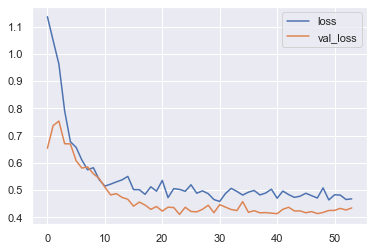

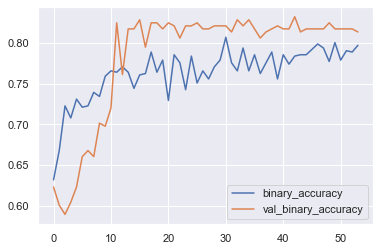

In [150]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

<h2> Confusion Matrix and Accuracy for Validation Data

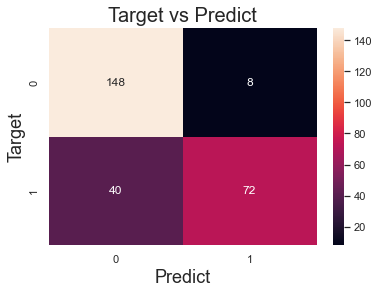


9/9 [==============================] - 0s 10ms/step - loss: 0.4108 - binary_accuracy: 0.8209
Loss = 0.4108163118362427
Accuracy(Test Data)= 0.8208954930305481


In [155]:
y_pred = model.predict(X_val)
y_pred = y_pred.round()

confusion_matrix = tf.math.confusion_matrix(y_val,y_pred)
ax=sns.heatmap(confusion_matrix, annot=True, fmt="d")
ax.set_xlabel("Predict",size=18);
ax.set_ylabel("Target",size=18);
ax.set_title("Target vs Predict",size=20);
plt.show()

print()
# Evaluation using all the samples of the test set
evaluations = model.evaluate(x=X_val, y=y_val)
print ("Loss = " + str(evaluations[0]))
print ("Accuracy(Test Data)= " + str(evaluations[1]))

# Submission

In [156]:
y_pred_test = model.predict(X_test)
y_pred_test=y_pred_test.round()
submit=pd.DataFrame(X_test.index)
submit[Config.TARGET_COL] = y_pred_test
submit[Config.TARGET_COL] = submit[Config.TARGET_COL].astype('int')

submit.set_index("PassengerId",inplace=True)

In [157]:
submit.to_csv('submit_NNetwok_'+str(evaluations[1]*100)[0:5]+'.csv')
print('submit_NNetwork_'+str(evaluations[1]*100)[0:5]+'.csv')

submit_NNetwork_82.08.csv


# Borrar